In [1]:
# For data loading and scientific computing
import pandas as pd
import numpy as np
import random
import os

# For data visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Deep learning framework
import torch
import torch.nn as nn

# data processing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score 

## config

In [2]:
    
class config:

    batch_size = 16
    lr = 1e-3
    epochs = 100
    weight_decay = 1e-2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

## seed

In [3]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


## file

In [4]:
train_data = pd.read_csv('/kaggle/input/dlmia-1/zip.train1.csv', header=None)
test_data = pd.read_csv('/kaggle/input/dlmia-1/zip.test1.csv', header=None)

print(f"Number of training samples: {train_data.shape[0]}")
print(f"Number of testing samples: {test_data.shape[0]}")   # test沒有label

Number of training samples: 7291
Number of testing samples: 2007


## Pytorch Dataset

In [5]:
class HandwrittenDigits(torch.utils.data.Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __getitem__(self, x):
        image, label = self.df.iloc[x, 1:].to_numpy(), self.df.iloc[x, 0]
        image, label = torch.tensor(image), torch.tensor(label)
        return image, label
        
    def __len__(self):
        return self.df.shape[0]
    
ds = HandwrittenDigits(train_data)

## split data to train and valid

In [6]:
def split_ids(n, train_size, val_size):
    train_size = int(train_size * n)
    val_size = int(val_size * n)

    train_indices, val_size = train_test_split(
        np.linspace(0, n - 1, n).astype("int"),
        test_size=val_size,
        random_state=123,
    )

    return train_indices, val_size

## Pytorch DataLoader

In [7]:
dataset = HandwrittenDigits(train_data)
train_ids, val_ids = split_ids(train_data.shape[0], 0.8, 0.2)
train_dataset = torch.utils.data.Subset(dataset, train_ids)
val_dataset = torch.utils.data.Subset(dataset, val_ids)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

## plot train

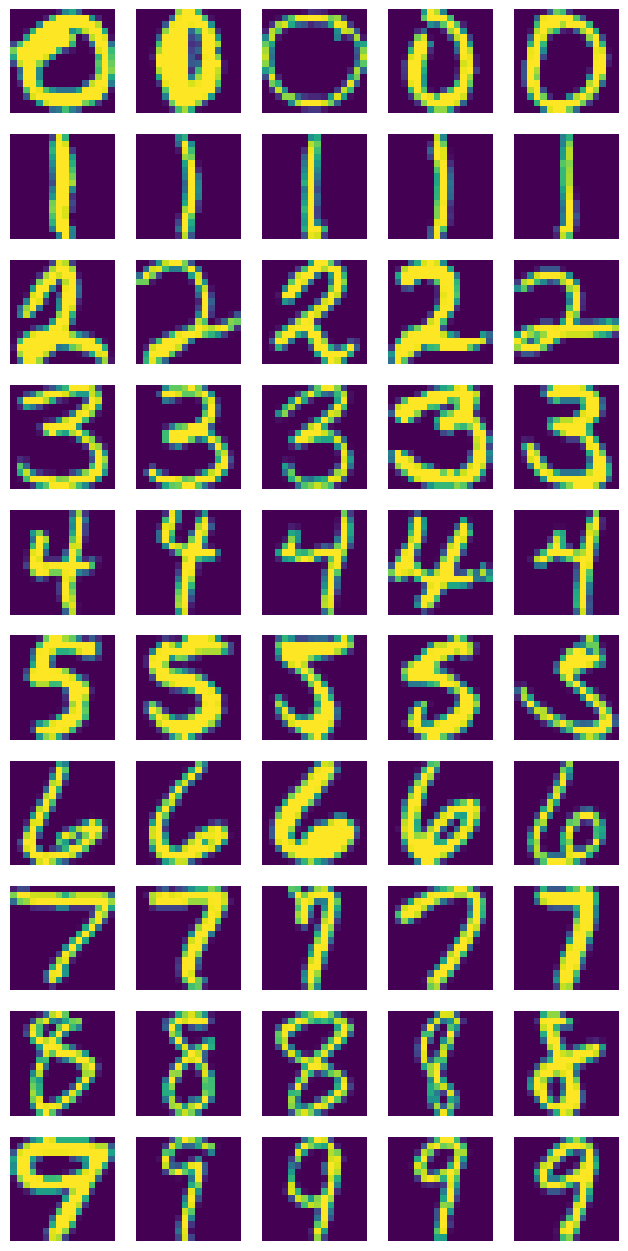

In [8]:
train_loader_plt = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True)

images, labels = next(iter(train_loader_plt))


plt.figure(figsize=(16,16))
count_per_label = {label: 0 for label in range(0, 10)}

for i, (image, label) in enumerate(zip(images, labels)):
    if count_per_label[int(label)] < 5:
        image = image.numpy().reshape(16, 16)

        plt.subplot(10, 10, int(10 * (label - 1) + count_per_label[int(label)] + 11))
        plt.imshow(image, vmin=-1, vmax=1)
        plt.axis('off')
        plt.subplots_adjust(wspace=None, hspace=None)

        count_per_label[int(label)] += 1


plt.show()

## Pytorch Module

# Model1
### One hidden layer with 12 nodes

In [9]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [10]:
input_dim =  256
hidden_dim = 12
output_dim = 10

model = SimpleNN(input_dim, hidden_dim, output_dim)

## Training

In [11]:
def evaluator(preds, gts):
    
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")
    
    return acc, f1

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []
    for images, labels in train_loader:
        images = images.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        
        predictions.append(preds)
        ground_truths.append(labels)
        
    train_loss /= len(train_loader)
    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)
    
    return train_loss, 100*train_acc, 100*train_f1
        
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images)
            loss = criterion(logits, labels)
            
            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
        
            predictions.append(preds)
            ground_truths.append(labels)
        
    valid_loss /= len(valid_loader)
    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1
    

Epoch[1/100], Train Loss: 2.2825, Train Accuracy: 20.81%, Train F1: 11.91% | Valid Loss: 2.2489, Valid Accuracy: 30.86%, Valid F1: 20.26% | LR: 0.000043
Epoch[2/100], Train Loss: 2.1830, Train Accuracy: 38.35%, Train F1: 21.28% | Valid Loss: 2.1256, Valid Accuracy: 38.00%, Valid F1: 19.18% | LR: 0.000050
Epoch[3/100], Train Loss: 2.0716, Train Accuracy: 42.86%, Train F1: 22.92% | Valid Loss: 2.0494, Valid Accuracy: 42.80%, Valid F1: 23.47% | LR: 0.000063
Epoch[4/100], Train Loss: 2.0067, Train Accuracy: 47.56%, Train F1: 27.98% | Valid Loss: 1.9956, Valid Accuracy: 50.41%, Valid F1: 31.68% | LR: 0.000082
Epoch[5/100], Train Loss: 1.9601, Train Accuracy: 53.39%, Train F1: 33.50% | Valid Loss: 1.9592, Valid Accuracy: 51.85%, Valid F1: 32.96% | LR: 0.000104
Epoch[6/100], Train Loss: 1.9267, Train Accuracy: 54.93%, Train F1: 35.28% | Valid Loss: 1.9273, Valid Accuracy: 54.46%, Valid F1: 37.18% | LR: 0.000132
Epoch[7/100], Train Loss: 1.8878, Train Accuracy: 60.71%, Train F1: 43.57% | Valid

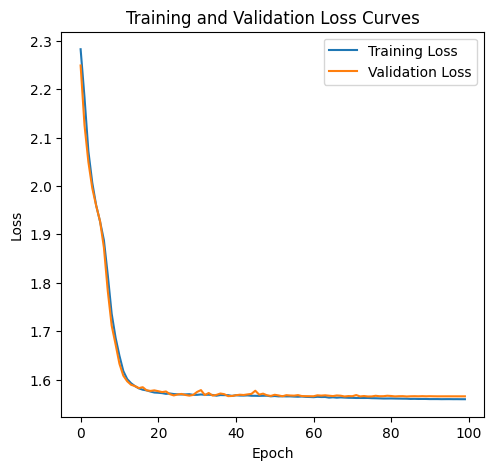

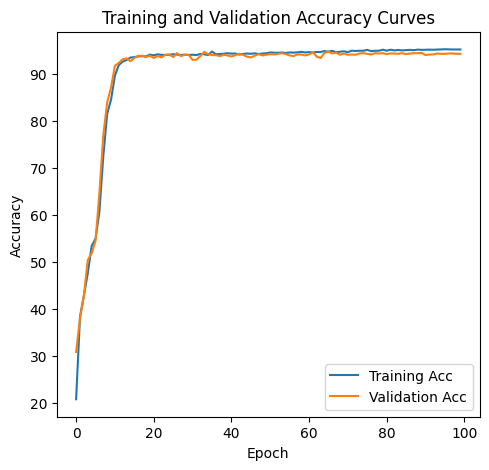

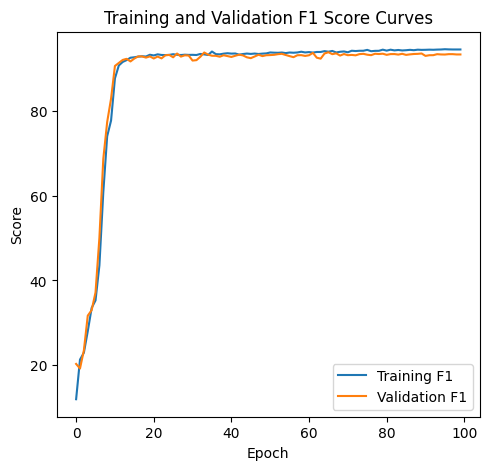

In [12]:
def main():
    
    seed_everything(config.seed)
    
    dataset = HandwrittenDigits(train_data)
    train_ids, val_ids = split_ids(train_data.shape[0], 0.8,0.2)
    train_dataset = torch.utils.data.Subset(dataset, train_ids)
    val_dataset = torch.utils.data.Subset(dataset, val_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    device = config.device
    model =  SimpleNN(input_dim, hidden_dim, output_dim)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        epochs=config.epochs, 
        steps_per_epoch=train_loader.__len__(),
        max_lr=config.lr,
    )
    
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": []
        },
    }
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
        valid_loss, valid_acc, valid_f1 = validation(model, val_loader, criterion, device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
    
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")
            
    best_ckpt = torch.load("checkpoint.pth", map_location=device)
    model.load_state_dict(best_ckpt["model"])
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
        
if __name__ == "__main__":
    main()

## predict test

In [13]:
# Pytorch Dataset

class HandwrittenDigits_fortest(torch.utils.data.Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __getitem__(self, x):
        image = self.df.iloc[x, 0:].to_numpy()
        image = torch.tensor(image)
        return image
        
    def __len__(self):
        return self.df.shape[0]

# Pytorch DataLoader
test_dataset = HandwrittenDigits_fortest(test_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)


# predict test data
device = config.device

def test(model, test_loader, device):
    
    model.eval()   
    predictions = []
    prob = []
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device=device, dtype=torch.float)

            logits = model(images)
            
            probs = logits.softmax(dim=1)
            preds = torch.argmax(probs, dim=1)
            
            
            predictions.append(preds)
            prob.append(probs)
            
    predictions = torch.cat(predictions,dim=0)   
    prob = torch.cat(prob,dim=0)
    
    return predictions,prob

state_dict = torch.load("checkpoint.pth") 
model.load_state_dict(state_dict["model"]) 

pred ,p = test(model, test_loader, device) #

pred_array = pred.cpu().numpy() 
p_array = p.cpu().numpy()

## check predict

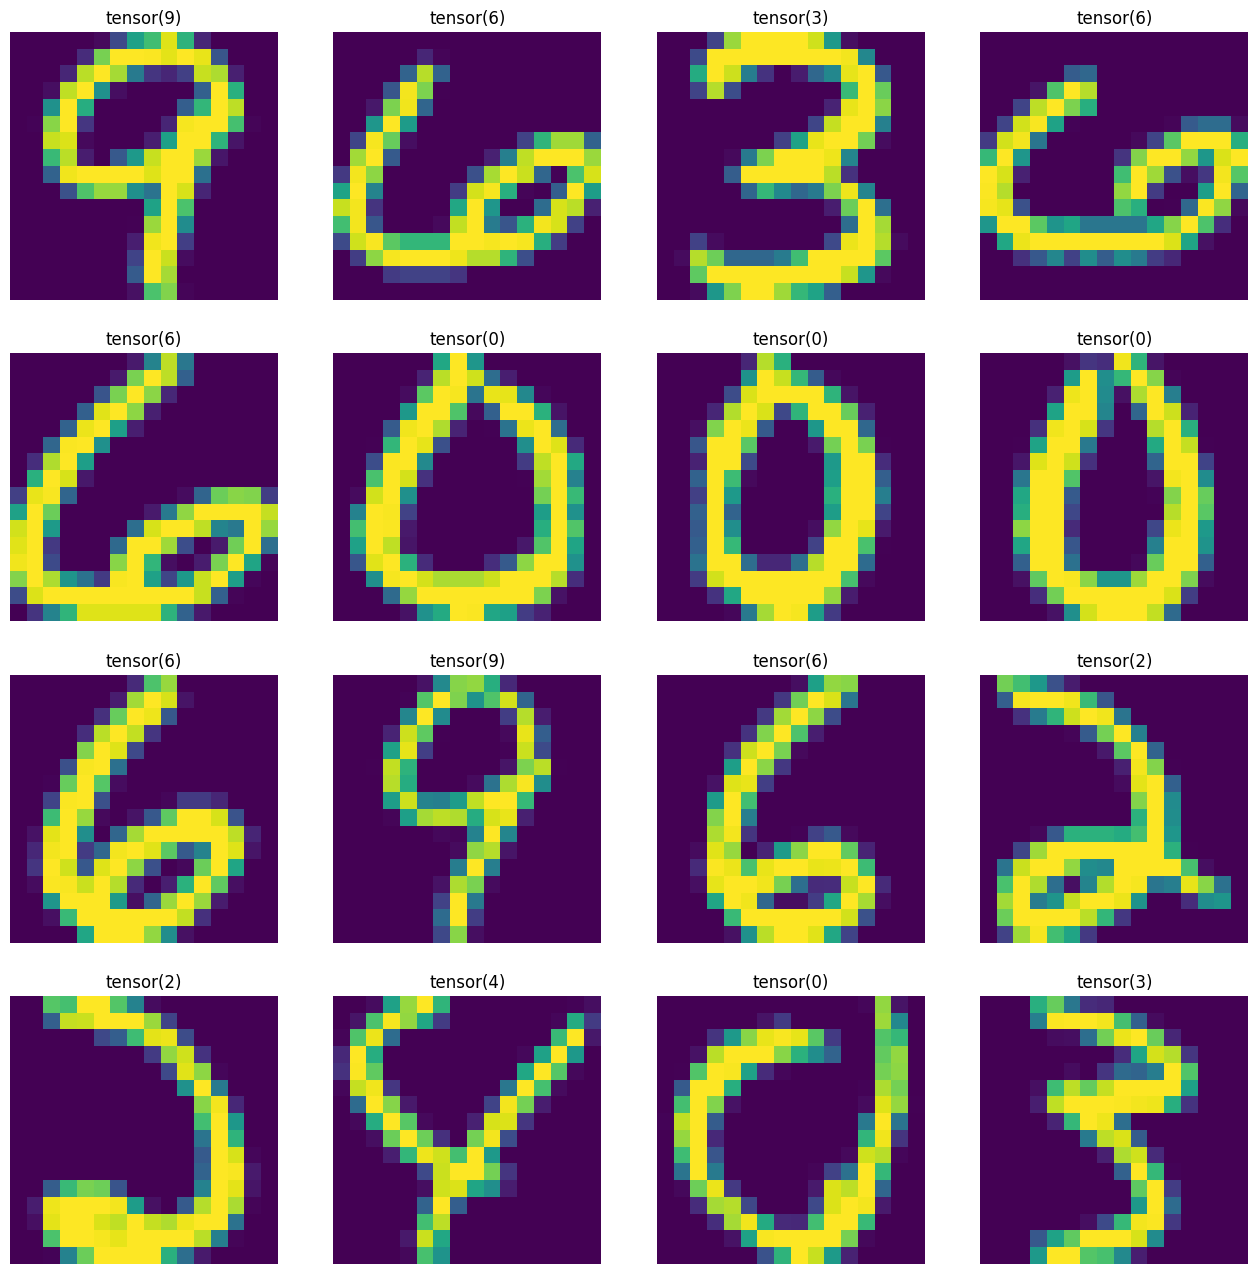

In [14]:
num_images = 16
images = next(iter(test_loader))
images = images[:16]

plt.figure(figsize=(16,16))

for i, (image) in enumerate(images):
    image = image.numpy().reshape(16, 16)

    plt.subplot(4,4,i+1)
    plt.imshow(image,vmin=-1,vmax=1)
    plt.title(pred[i])
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

# Model_2
### Two hidden layers with 64 and 16 nodes, respectively

In [15]:
class SimpleNN_2(nn.Module):
    def __init__(self, input_dim, hidden_dim_1,hidden_dim_2, output_dim):
        super(SimpleNN_2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim_2, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out
    
input_dim =  256
hidden_dim_1 = 64
hidden_dim_2 = 16
output_dim = 10

model_2 = SimpleNN_2(input_dim, hidden_dim_1,hidden_dim_2, output_dim)

# Training

Epoch[1/100], Train Loss: 2.2855, Train Accuracy: 28.20%, Train F1: 13.36% | Valid Loss: 2.2540, Valid Accuracy: 33.74%, Valid F1: 15.75% | LR: 0.000043
Epoch[2/100], Train Loss: 2.1995, Train Accuracy: 32.78%, Train F1: 17.02% | Valid Loss: 2.1578, Valid Accuracy: 40.26%, Valid F1: 21.28% | LR: 0.000050
Epoch[3/100], Train Loss: 2.0955, Train Accuracy: 40.55%, Train F1: 20.16% | Valid Loss: 2.0515, Valid Accuracy: 40.60%, Valid F1: 21.63% | LR: 0.000063
Epoch[4/100], Train Loss: 2.0093, Train Accuracy: 47.44%, Train F1: 29.79% | Valid Loss: 1.9730, Valid Accuracy: 54.32%, Valid F1: 38.82% | LR: 0.000082
Epoch[5/100], Train Loss: 1.9217, Train Accuracy: 59.56%, Train F1: 42.31% | Valid Loss: 1.8874, Valid Accuracy: 61.80%, Valid F1: 45.64% | LR: 0.000104
Epoch[6/100], Train Loss: 1.8413, Train Accuracy: 67.99%, Train F1: 54.18% | Valid Loss: 1.7991, Valid Accuracy: 73.32%, Valid F1: 61.21% | LR: 0.000132
Epoch[7/100], Train Loss: 1.7558, Train Accuracy: 79.43%, Train F1: 71.35% | Valid

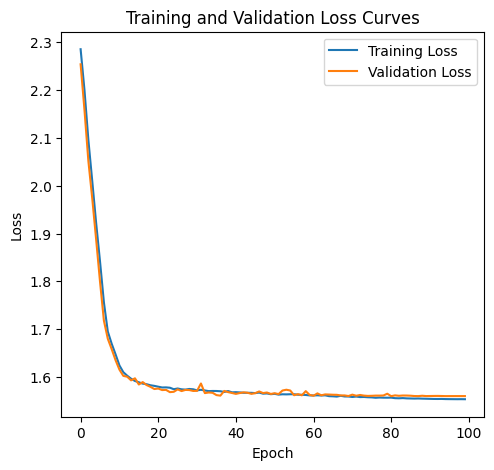

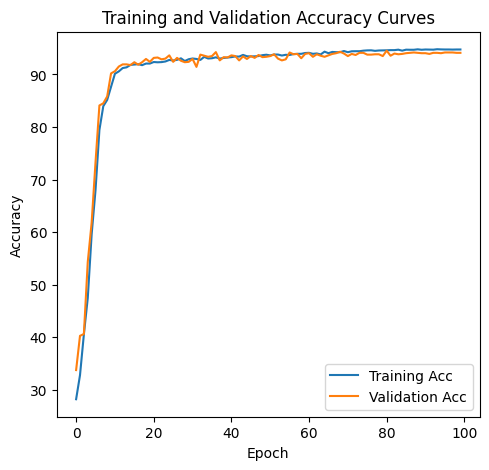

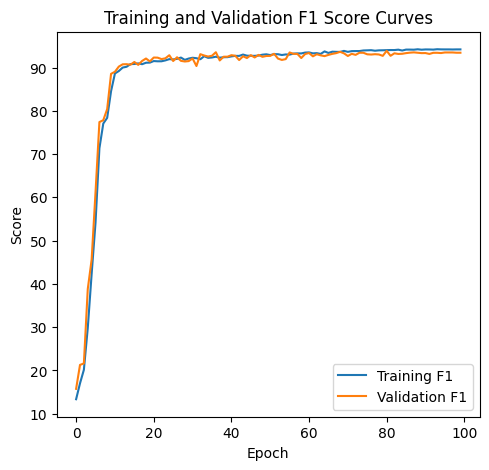

In [16]:
def main():
    
    seed_everything(config.seed)
    
    dataset = HandwrittenDigits(train_data)
    train_ids, val_ids = split_ids(train_data.shape[0], 0.8,0.2)
    train_dataset = torch.utils.data.Subset(dataset, train_ids)
    val_dataset = torch.utils.data.Subset(dataset, val_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    device = config.device
    model_2 = SimpleNN_2(input_dim, hidden_dim_1,hidden_dim_2, output_dim)
    model_2.to(device)
    optimizer = torch.optim.Adam(model_2.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        epochs=config.epochs, 
        steps_per_epoch=train_loader.__len__(),
        max_lr=config.lr,
    )
    
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": []
        },
    }
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model_2, train_loader, optimizer, scheduler, criterion, device)
        valid_loss, valid_acc, valid_f1 = validation(model_2, val_loader, criterion, device)
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
    
        if valid_loss < best_val_loss:
            save_file = {
                "model_2": model_2.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_2.pth")
            
    best_ckpt = torch.load("checkpoint_2.pth", map_location=device)
    model_2.load_state_dict(best_ckpt["model_2"])
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
        
if __name__ == "__main__":
    main()

## predict test

In [17]:
# predict test data

state_dict = torch.load("checkpoint_2.pth") 
model_2.load_state_dict(state_dict["model_2"]) 

pred_2 ,p_2 = test(model_2, test_loader, device) 

pred_array_2 = pred_2.cpu().numpy() 
p_array_2 = p_2.cpu().numpy()

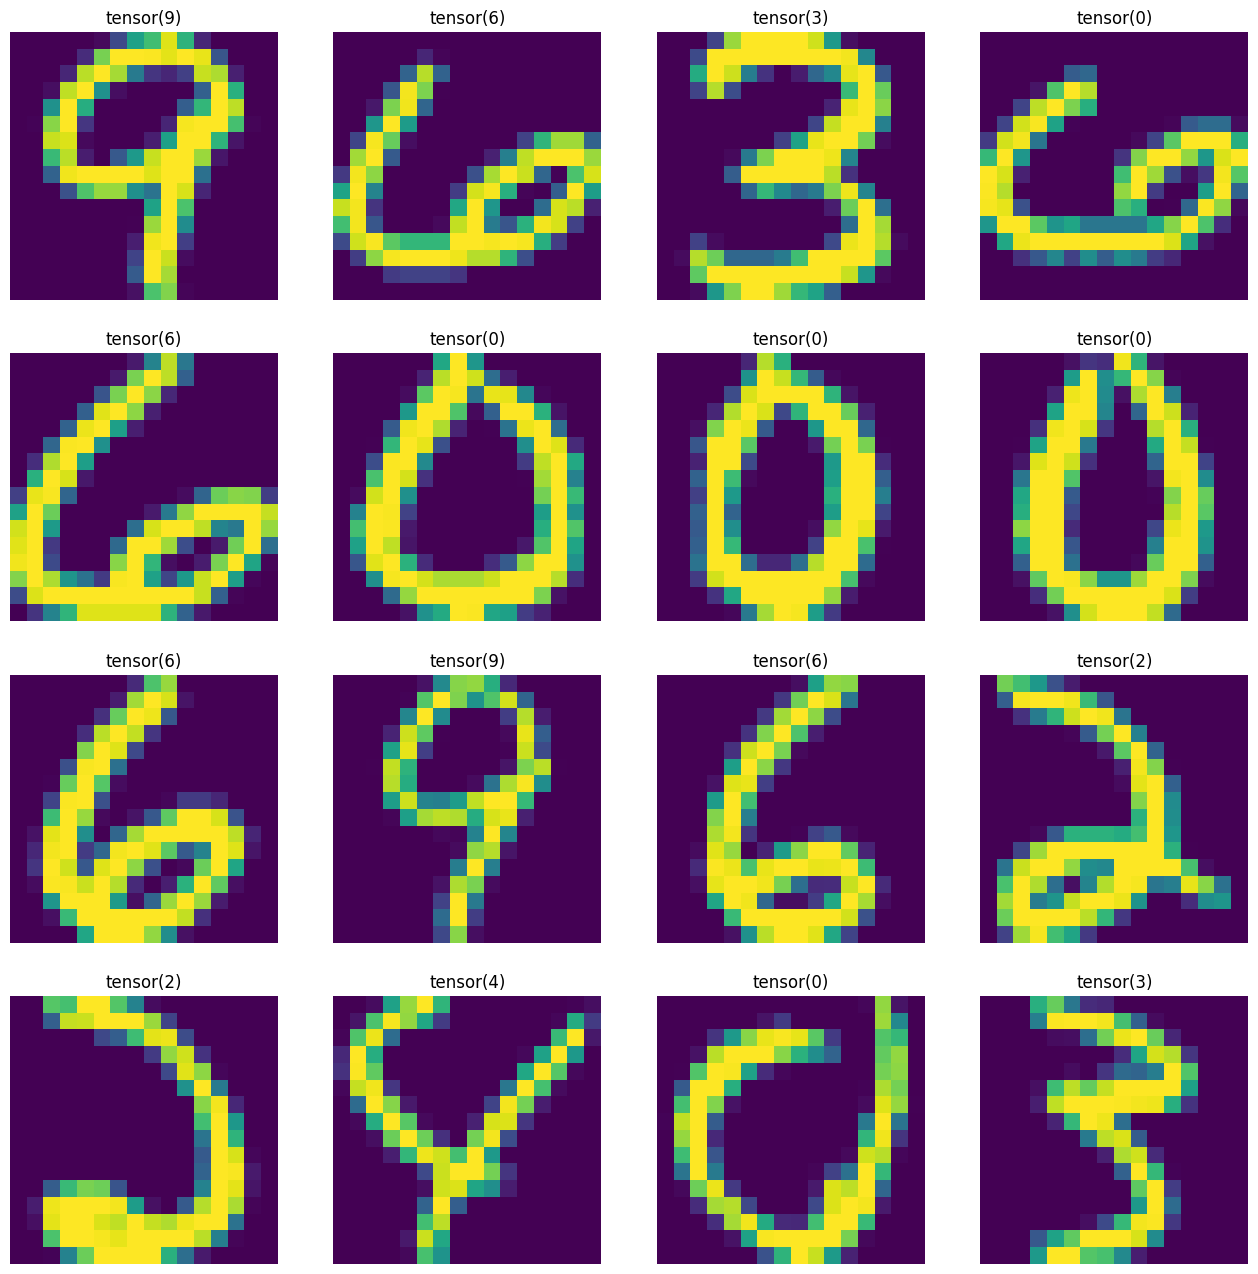

In [18]:
## 看預測資料是否正常
num_images = 16
images = next(iter(test_loader))
images = images[:16]

plt.figure(figsize=(16,16))

for i, (image) in enumerate(images):
    image = image.numpy().reshape(16, 16)

    plt.subplot(4,4,i+1)
    plt.imshow(image,vmin=-1,vmax=1)
    plt.title(pred_2[i])
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)